In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from models.dynamic_loss import DynamicWeightedLoss
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS

import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

common_args = {
    "use_custom_model": True,
    "use_early_stop_model": True,
    "optimiser": "sgd",
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "pretrained": True,
    "record_training_performance": True,
    "dataset_mode": "normal",
    "image_size": 512,
    "batch_size": 4,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": True,
    # "clinical_num_len": len(DEFAULT_MIMIC_CLINICAL_NUM_COLS),
    "gt_in_train_till": 999,
    "box_head_dropout_rate": 0,
    "spatialise_method": "convs",  # [convs, repeat]
    "normalise_clinical_num": False,
    "measure_test": True,
}

fusion_add_args = {
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "add",
}

fusion_concat_args = {
    "fuse_depth": 1,
    "fusion_residule": False,
    "fusion_strategy": "concat",
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "clinical_input_channels": 64,
    "representation_size": 64,  # 32
    "clinical_conv_channels": 64,
    "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

large_model_args = {
    "mask_hidden_layers": 256,
    "fuse_conv_channels": 256,
    "clinical_input_channels": 256,
    "representation_size": 256,  # 32
    "clinical_conv_channels": 256,
    "clinical_expand_conv_channels": 256,
    "backbone_out_channels": 256,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet_args = {
    "using_fpn": True,
    "backbone": "resnet50",
}

# patience=10, but start with 1e-2.
all_model_setups = [
    # ModelSetup(
    #     name="CXR_Clinical_fusion1_fusino2",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **{**common_args, "normalise_clinical_num": True},
    #     **fusion_add_args,
    # ),
    ########## Abalation for input data ##########
    # ModelSetup(
    #     name="MDF-Net (age+temp+heartrate+resprate+o2sat)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num =  [
    #         "age",
    #         "temperature",
    #         "heartrate",
    #         "resprate",
    #         "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat = [
    #         # "gender"
    #     ],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    # ModelSetup(
    #     name="MDF-Net (gender)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num =  [
    #         # "age",
    #         # "temperature",
    #         # "heartrate",
    #         # "resprate",
    #         # "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat = [
    #         "gender"
    #     ],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    # ModelSetup(
    #     name="MDF-Net (gender+age)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num=[
    #         "age",
    #         # "temperature",
    #         # "heartrate",
    #         # "resprate",
    #         # "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat=["gender"],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    # ModelSetup(
    #     name="MDF-Net (gender+temp)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num=[
    #         # "age",
    #         "temperature",
    #         # "heartrate",
    #         # "resprate",
    #         # "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat=["gender"],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    # ModelSetup(
    #     name="MDF-Net (gender+heartrate)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num=[
    #         # "age",
    #         # "temperature",
    #         "heartrate",
    #         # "resprate",
    #         # "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat=["gender"],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    #  ModelSetup(
    #     name="MDF-Net (gender+resprate)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num =  [
    #         # "age",
    #         # "temperature",
    #         # "heartrate",
    #         "resprate",
    #         "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat = [
    #         "gender"
    #     ],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    #  ModelSetup(
    #     name="MDF-Net (gender+age+temp)",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    #     including_clinical_num =  [
    #         "age",
    #         "temperature",
    #         # "heartrate",
    #         # "resprate",
    #         # "o2sat",
    #         # "sbp",
    #         # "dbp",
    #         # "pain",
    #         # "acuity",
    #     ],
    #     including_clinical_cat = [
    #         "gender"
    #     ],
    #     # pre_spatialised_layer= 2 # [2, 1]
    # ),
    ModelSetup(
        name="MDF-Net (gender+age+heartrate)",
        use_clinical=True,
        spatialise_clinical=True,
        add_clinical_to_roi_heads=True,
        **mobilenet_args,
        **small_model_args,
        **common_args,
        **fusion_add_args,
        including_clinical_num =  [
            "age",
            # "temperature",
            "heartrate",
            # "resprate",
            # "o2sat",
            # "sbp",
            # "dbp",
            # "pain",
            # "acuity",
        ],
        including_clinical_cat = [
            "gender"
        ],
        # pre_spatialised_layer= 2 # [2, 1]
    ),
    ModelSetup(
        name="MDF-Net (gender+age+resprate)",
        use_clinical=True,
        spatialise_clinical=True,
        add_clinical_to_roi_heads=True,
        **mobilenet_args,
        **small_model_args,
        **common_args,
        **fusion_add_args,
        including_clinical_num =  [
            "age",
            # "temperature",
            # "heartrate",
            "resprate",
            # "o2sat",
            # "sbp",
            # "dbp",
            # "pain",
            # "acuity",
        ],
        including_clinical_cat = [
            "gender"
        ],
        # pre_spatialised_layer= 2 # [2, 1]
    ),
    #################################################################
    # ModelSetup(
    #     name="CXR_Clinical_fusion1",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=False,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    # ),
    # ModelSetup(
    #     name="CXR_Clinical_fusion2",
    #     use_clinical=True,
    #     spatialise_clinical=False,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    # ),
    # ModelSetup(
    #     name="CXR",
    #     use_clinical=False,
    #     spatialise_clinical=False,
    #     add_clinical_to_roi_heads=False,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    # ),
    # ModelSetup(
    #     name="CXR_Clinical_fusion1_fusino2",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_concat_args,
    # ),
    # ModelSetup(
    #     name="CXR_Clinical_fusion1_fusino2",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **{**common_args, "spatialise_method":"repeat"},
    #     **fusion_add_args,
    # ),
    #     ModelSetup(
    #     name="CXR_Clinical_fusion1_fusino2",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **{**common_args, "spatialise_method":"repeat"},
    #     **fusion_concat_args,
    # ),
]

### [TODO] ###

# [ ] - enlarge the size of the image, more input data may mean a better generalization we need.
# [ ]


In [4]:
num_epochs = 50 # 100
train_infos = []

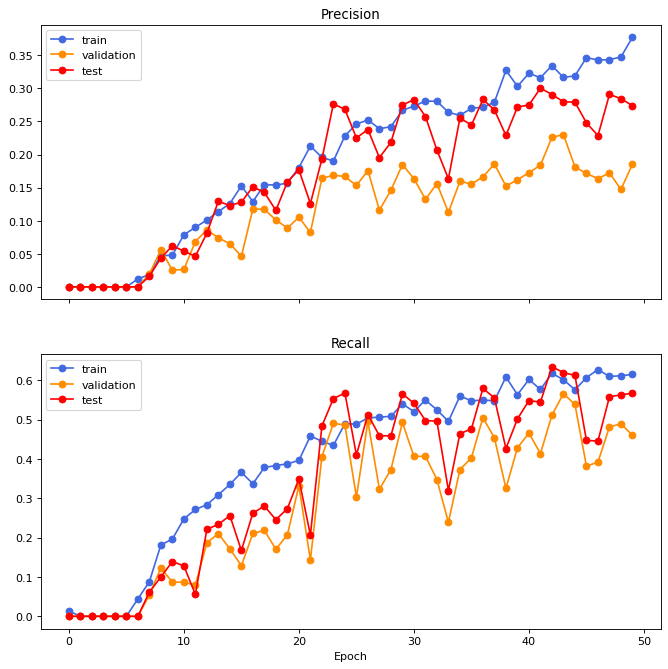

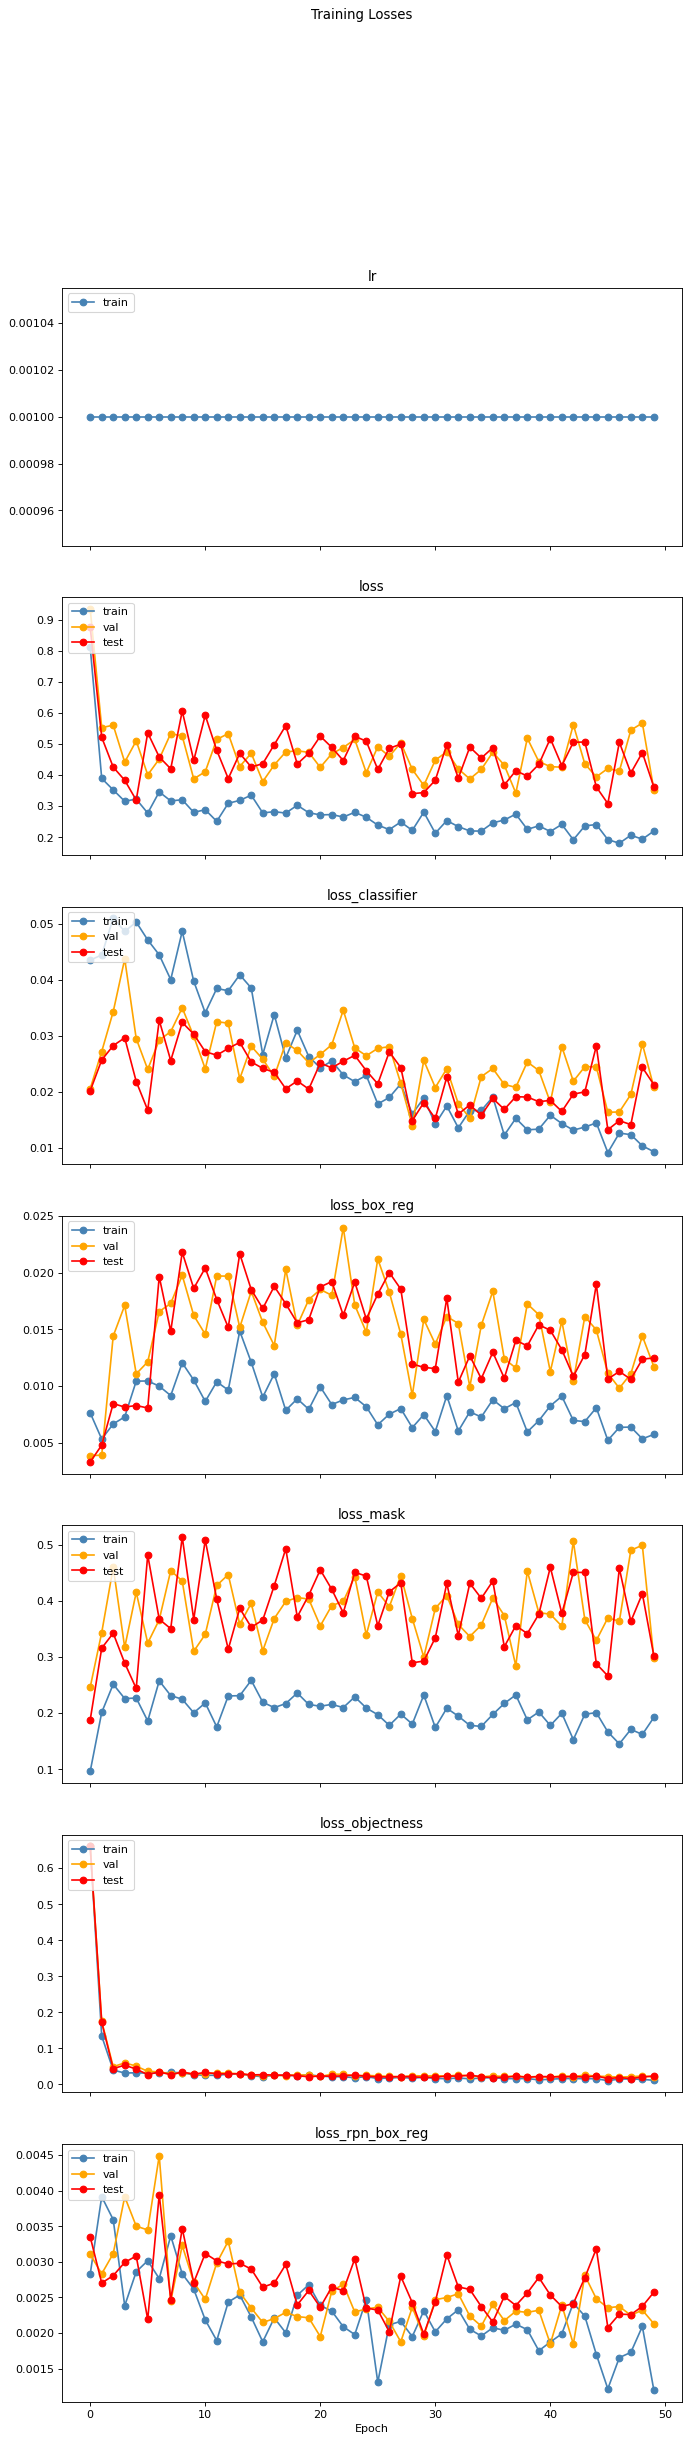

====================| Epoch [50] Done | It has took [169.60] min, Avg time: [203.52] sec/epoch | Estimate time for [50] epochs: [169.60] min | Epoch took [211] sec | Patience [12] |====================
====================| Training Done, start testing! | [50] Epochs Training time: [10176] seconds, Avg time / Epoch: [203.52] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_5659_ap_0_2302_test_ar_0_6194_ap_0_2798_epoch44_WithClincal_09-21-2022 08-38-02_MDF-Net (gender+age+resprate)]====================
====================Best AR validation model has been saved to: [val_ar_0_5659_ap_0_2302_test_ar_0_6194_ap_0_2798_epoch44_WithClincal_09-21-2022 08-38-02_MDF-Net (gender+age+resprate)]====================
Evaluation:  [ 0/26]  eta: 0:00:25  loss: 0.1233 (0.1233)  loss_classifier: 0.0052 (0.0052)  loss_box_reg: 0.0032 (0.0032)  loss_mask: 0.1116 (0.1116)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0001 (0.0001)  model_time: 0.

In [5]:
## we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

for model_setup in all_model_setups:

    

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    if model_setup.measure_test:
        # initialise the test recording list.
        train_info.test_ap_ars = []

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.to(device)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": model_setup.use_mask,
        "normalise_clinical_num": model_setup.normalise_clinical_num,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )

            # set the clinical data if clinical data is used.
    if model_setup.use_clinical:
        # set for every dataset 
        train_dataloader.dataset.set_clinical_features_used(model_setup.including_clinical_num, model_setup.including_clinical_cat)
        val_dataloader.dataset.set_clinical_features_used(model_setup.including_clinical_num, model_setup.including_clinical_cat)
        test_dataloader.dataset.set_clinical_features_used(model_setup.including_clinical_num, model_setup.including_clinical_cat)

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    # dynamic_loss_weight = None
    loss_keys = [
        "loss_classifier",
        "loss_box_reg",
        "loss_objectness",
        "loss_rpn_box_reg"
    ]
    
    dynamic_loss_weight = DynamicWeightedLoss(
        keys=loss_keys + ["loss_mask"] if model_setup.use_mask else loss_keys
    )
    dynamic_loss_weight.to(device)
    print_params_setup(model)

    params = [p for p in model.parameters() if p.requires_grad]
    if dynamic_loss_weight:
        params += [p for p in dynamic_loss_weight.parameters() if p.requires_grad]

    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(params, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Took [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    ## Start the training from here.
    for e in range(num_epochs):



        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        if train_info.epoch > model_setup.gt_in_train_till:
            model.roi_heads.use_gt_in_train  = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            setup=model_setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            setup=model_setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        if model_setup.measure_test:
            train_info.test_evaluator, test_logger = xami_evaluate(
                setup=model_setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))
            test_ap_ar = get_ap_ar(
                train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
            )
            train_info.test_ap_ars.append(test_ap_ar)

        ### update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        if train_info.epoch > model_setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        model_setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= model_setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

        plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                setup=model_setup,
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    train_info = end_train(
        setup=model_setup,
        train_info=train_info,
        model=model,        
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


In [6]:
train_info.removed_model_paths

[None,
 'val_ar_0_0000_ap_0_0000_test_ar_0_0000_ap_0_0000_epoch1_WithClincal_09-21-2022 06-13-04_MDF-Net (gender+age+resprate)',
 'val_ar_0_0542_ap_0_0193_test_ar_0_0613_ap_0_0160_epoch8_WithClincal_09-21-2022 06-30-07_MDF-Net (gender+age+resprate)',
 'val_ar_0_1228_ap_0_0560_test_ar_0_1000_ap_0_0434_epoch9_WithClincal_09-21-2022 06-33-21_MDF-Net (gender+age+resprate)',
 'val_ar_0_0792_ap_0_0685_test_ar_0_0556_ap_0_0462_epoch12_WithClincal_09-21-2022 06-42-32_MDF-Net (gender+age+resprate)',
 'val_ar_0_2100_ap_0_0740_test_ar_0_2337_ap_0_1294_epoch14_WithClincal_09-21-2022 06-49-42_MDF-Net (gender+age+resprate)',
 'val_ar_0_1870_ap_0_0861_test_ar_0_2213_ap_0_0811_epoch13_WithClincal_09-21-2022 06-46-07_MDF-Net (gender+age+resprate)',
 'val_ar_0_2107_ap_0_1177_test_ar_0_2622_ap_0_1512_epoch17_WithClincal_09-21-2022 06-59-36_MDF-Net (gender+age+resprate)',
 'val_ar_0_2181_ap_0_1171_test_ar_0_2803_ap_0_1426_epoch18_WithClincal_09-21-2022 07-03-11_MDF-Net (gender+age+resprate)',
 'val_ar_0_3

In [7]:
train_info.best_ap_val_model_path

'val_ar_0_5659_ap_0_2302_test_ar_0_6194_ap_0_2798_epoch44_WithClincal_09-21-2022 08-38-02_MDF-Net (gender+age+resprate)'

In [8]:
train_info.best_ar_val_model_path

'val_ar_0_5659_ap_0_2302_test_ar_0_6194_ap_0_2798_epoch44_WithClincal_09-21-2022 08-38-02_MDF-Net (gender+age+resprate)'

========================================For Training [MDF-Net (gender+age+heartrate)]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='MDF-Net (gender+age+heartrate)', backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, pretrained=True, record_training_performance=True, dataset_mode='normal', image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, clinical_input_channels=64, clinical_expand_conv_channels=64, including_clinical_num=['age', 'heartrate'], including_clinical_cat=['gender'], clinical_conv_channels=64, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, spatialise_clinical=True, add_clinical_to_roi

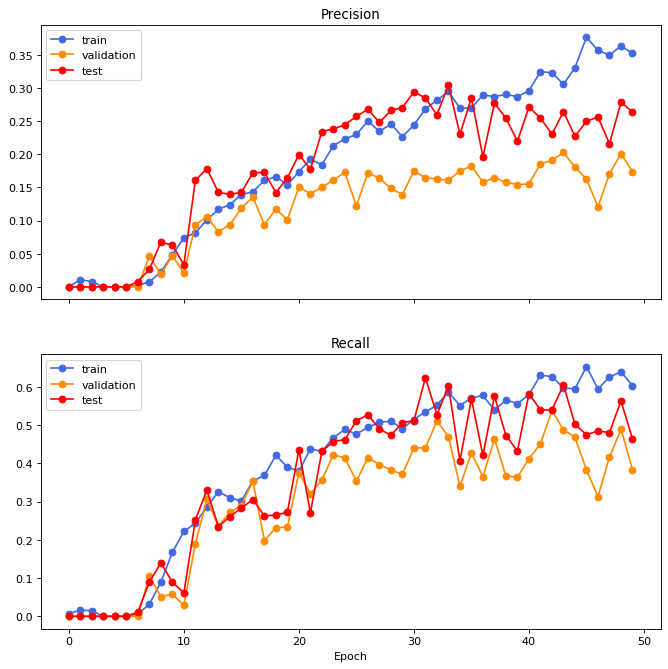

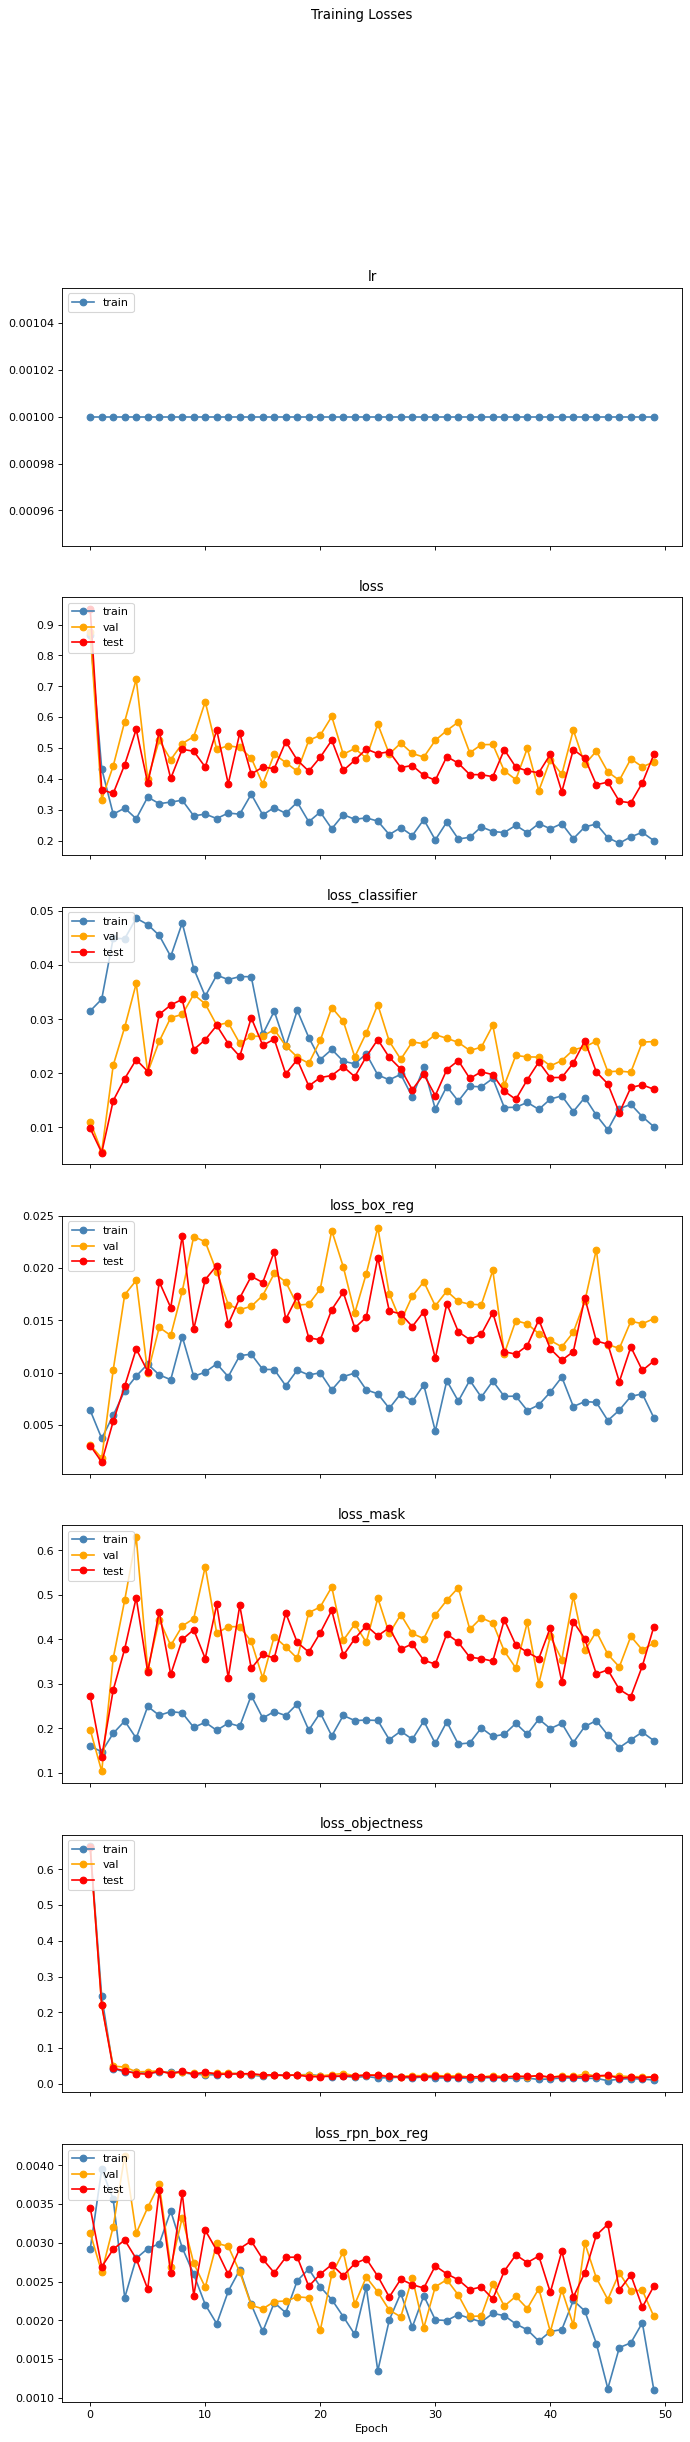

========================================For Training [MDF-Net (gender+age+resprate)]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='MDF-Net (gender+age+resprate)', backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, pretrained=True, record_training_performance=True, dataset_mode='normal', image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, clinical_input_channels=64, clinical_expand_conv_channels=64, including_clinical_num=['age', 'resprate'], including_clinical_cat=['gender'], clinical_conv_channels=64, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, spatialise_clinical=True, add_clinical_to_roi_he

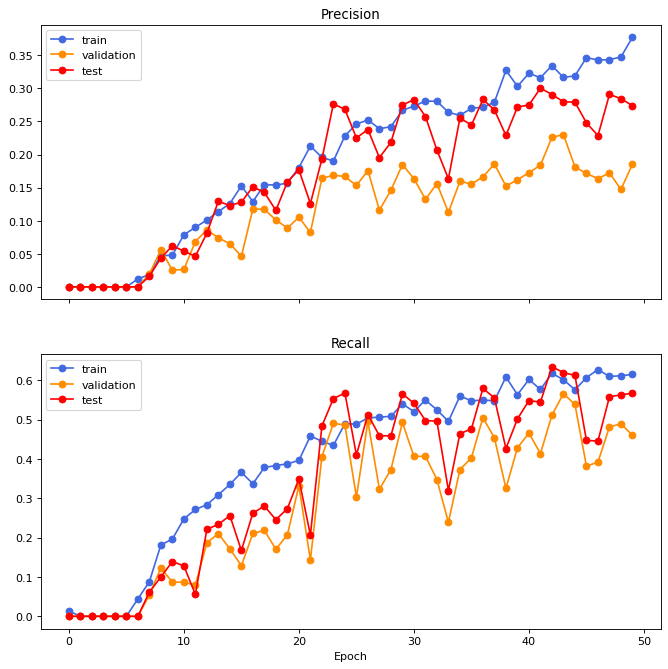

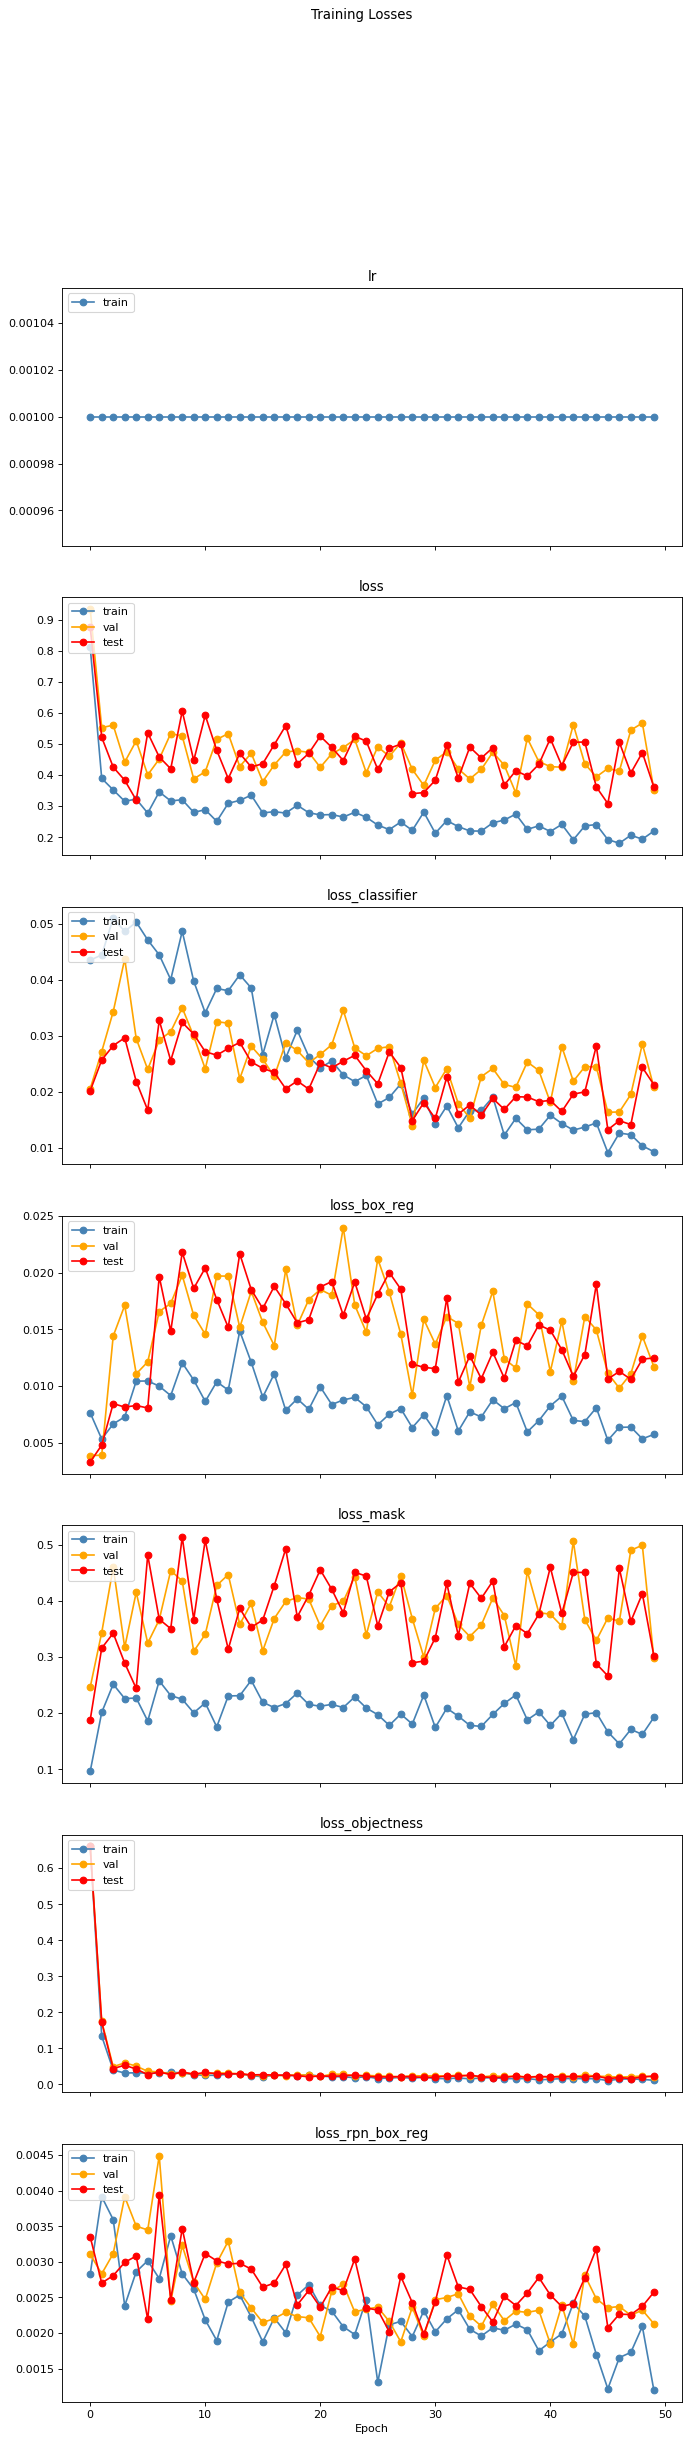

In [9]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    print(f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]")
    plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

    plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)

